In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.matlib import repmat

from timeit import default_timer as timer

import tqdm

import scipy

from handythread import foreach
import cython

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [141]:
# Objective functions

class FunctionCompilation():
    # feval equivalent
    def callFunction(self, name, val):
        fn = getattr(self, name, None)
        if fn is not None:
            return fn(val)
        else:
            print('Undefined function call')
            return
        
        
    def ackley(self, val):
        dim = val.shape[1]
        
        f1 = np.sum([val[:, :1 + dim]**2], axis=-1)
        f1 = np.reshape(f1, (f1.shape[1], f1.shape[0]))
        f2 = np.sum([np.cos(2*np.pi * val[:, :1+dim])], axis=-1)
        f2 = np.reshape(f2, (f2.shape[1], f2.shape[0]))
        
        return -20 * np.exp(-0.2 * np.sqrt(1/dim * f1)) - np.exp(1/dim * f2) + 20 + np.exp(1)
    
    
    def eso_obj(self, val):
        par = val['par']
        
        vals = val['var']
        
        i: cython.int
            
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
            
        t_range: cython.int[par['t'].shape[0]] = range(par['t'].shape[0])
        gen_range: cython.int[par['gen'].shape[0]] = range(par['gen'].shape[0])
        load_range: cython.int[par['load'].shape[0]] = range(par['load'].shape[0])
        stor_range: cython.int[par['stor'].shape[0]] = range(par['stor'].shape[0])
        v2g_range: cython.int[par['v2g'].shape[0]] = range(par['v2g'].shape[0])
            
        
        obj_value = []
        for i in np.arange(vals.shape[0]):
            var = decode(vals[i, :], val['var_names'])
            
            # Objective function values
            temp_gens = sum([var['genActPower'][g, t] * par['genLimit'][g, t, 2] + var['genExcActPower'][g, t] * par['genLimit'][g, t, 4]
                             for t in t_range for g in gen_range])
            
            temp_loads = sum([var['loadRedActPower'][l, t] * par['loadLimit'][l, t, 6] + var['loadCutActPower'][l, t] * par['loadLimit'][l, t, 7] + var['loadENS'][l, t] * par['loadLimit'][l, t, 9] 
                              for t in t_range for l in load_range])
            
            temp_stor = sum([var['storDchActPower'][s, t] * par['storLimit'][s, t, 3] - var['storChActPower'][s, t] * par['storLimit'][s, t, 2]# + var['EminRelaxStor'][s, t] * 200 
                             for t in t_range for s in stor_range])
            
            temp_v2g = sum([var['v2gDchActPower'][v, t] * par['v2gLimit'][v, t, 6] - var['v2gChActPower'][v, t] * par['v2gLimit'][v, t, 5]# + var['EminRelaxEv'][v, t] * 200
                            for t in t_range for v in v2g_range])
    
            temp_rest = sum([var['pImp'][t] * par['buyPrice'][t] - var['pExp'][t] * par['sellPrice'][t] 
                             for t in t_range])
        
            
            
            # Balance
            balance_gens = np.sum([var['genActPower'][g, t] - var['genExcActPower'][g, t] 
                                   for t in t_range for g in gen_range])
            
            balance_loads = np.sum([par['loadActPower'][l, t] - var['loadRedActPower'][l, t] - var['loadCutActPower'][l, t] - var['loadENS'][l, t]
                                   for t in t_range for l in load_range])
            
            balance_stor = np.sum([var['storChActPower'][s, t] - var['storDchActPower'][s, t]
                                  for t in t_range for s in stor_range])
            
            balance_v2g = np.sum([var['v2gChActPower'][v, t] - var['v2gDchActPower'][v, t]
                                  for t in t_range for v in v2g_range])
            
            balance_cs = np.sum([var['csActPowerNet'][:, t] for t in t_range])
            
            balance_rest = np.sum([var['pImp'][t] - var['pExp'][t]
                                   for t in t_range])
            
            balance = balance_gens + balance_rest - balance_loads  - balance_stor - balance_v2g - balance_cs
            
            
            obj_value.append(temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest + abs(balance)*100)
            #obj_value.append(temp_gens + temp_gens + temp_rest + temp_rest)
            
        obj_value = np.reshape(obj_value, (vals.shape[0], 1))
        
        return obj_value

In [4]:
# HyDE-DF parameters

class DEParams(object):
    
    def __init__(self, I_itermax=5e5, I_NP=50, F_weight=0.5, F_CR=0.9, I_bnd_constr=3, param_dictionary=None):
        
        ## Set parameters for HyDE-DF
        self.I_itermax = I_itermax
        self.I_NP = I_NP
        self.F_weight = F_weight
        self.F_CR = F_CR
        
        self.param_dictionary = None
        
        self.I_bnd_constr = I_bnd_constr #Using bound constraints is possible to change direct in DE
        # 1 repair to the lower or upper violated bound
        # 2 rand value in the allowed range
        # 3 bounce back
        
        
class OtherParameters(object):
    
    def __init__(self, objfun, dim, lowerlimit, upperlimit, var_dictionary=None, param_dictionary=None):
        self.objfun = objfun
        self.dim = dim
        self.lowerlimit = lowerlimit
        self.upperlimit = upperlimit
        
        self.var_dictionary = var_dictionary
        self.param_dictionary = param_dictionary

In [5]:
# Import and export checks

def check_pop_trading(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Import value checking
    mask = pop['pImp'] > par['pImp']
    pop['pImp'][mask] = par['pImp'][mask]
    
    mask = pop['pImp'] < 0
    pop['pImp'][mask] = 0
    
    
    # Export value checking
    mask = pop['pExp'] > par['pExp']
    pop['pExp'][mask] = par['pExp'][mask]
    
    mask = pop['pExp'] < 0
    pop['pExp'][mask] = 0
    
    return encode(pop)

In [216]:
# Generation checks

def check_pop_gens(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the boolean variables
    pop['genXo'] = (pop['genXo'] > 0.5).astype(int)
    
    g: cython.int
    gen_range: cython.int[pop['genActPower'].shape[0]] = range(pop['genActPower'].shape[0])
        
        
    # Go through generators
    for g in gen_range:
        
        # Maximum generation
        mask = pop['genActPower'][g, :] > par['genLimit'][g, :, 0]
        pop['genActPower'][g, :][mask] = par['genLimit'][g, :, 0][mask]
        
        # Minimum generation
        temp_vals = np.ones((1, pop['genActPower'].shape[1]))# * par['genInfo'][g, 6]       
        mask = pop['genActPower'][g, :] < temp_vals.ravel() #np.ones(par['genInfo'][g, 6] * pop['genXo'][g, :]
        pop['genActPower'][g, :][mask] = temp_vals.ravel()[mask]

        
        # Check generator type
        if par['genInfo'][g, 1] == 1:
            
            pop['genActPower'][g, :] = par['genLimit'][g, :, 0] * pop['genXo'][g, :]
            #pop['genActPower'][g, :] *= pop['genXo'][g, :]
            pop['genExcActPower'][g, :] *= 0 

        elif par['genInfo'][g, 1] == 2:
            # Generate the genExcActPower variable according to the equality equation
            pop['genExcActPower'][g, :] = par['genLimit'][g, :, 0] - pop['genActPower'][g, :]

    return encode(pop)

In [148]:
# Check loads

def check_pop_loads(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the boolean variables
    pop['loadXo'] = (pop['loadXo'] > 0.5).astype(int)
    
    # Build a matrix of ones
    temp_vals = np.ones((pop['loadRedActPower'].shape[0],
                         pop['loadRedActPower'].shape[1]))
    
    # RedAct value checks
    mask = pop['loadRedActPower'] > temp_vals * par['loadLimit'][:, :, 2]
    pop['loadRedActPower'][mask] = (temp_vals * par['loadLimit'][:, :, 2])[mask]
    
    mask = pop['loadRedActPower'] < 0
    pop['loadRedActPower'][mask] *= 0
    
    # LoadCut value checks
    mask = pop['loadCutActPower'] > temp_vals * par['loadLimit'][:, :, 3]
    pop['loadCutActPower'][mask] = (temp_vals * par['loadLimit'][:, :, 3])[mask]
    
    mask = pop['loadCutActPower'] < 0
    pop['loadCutActPower'][mask] *= 0
    
    pop['loadCutActPower'] *= pop['loadXo']
    
    # Go through the loads
    #pop['loadCutActPower'] = par['loadLimit'][:, :, 3] * pop['loadXo']
    
    # LoadENS
    temp_val = par['loadActPower'] - pop['loadRedActPower'] - pop['loadCutActPower']
    #mask = pop['loadENS'] > temp_val
    #pop['loadENS'][mask] = temp_val[mask]
    pop['loadENS'] = temp_val
    #pop['loadENS'][pop['loadENS'] > temp_val] = temp_val[pop['loadENS'] > temp_val]
    
    return encode(pop)

In [8]:
# Check storage

def check_pop_stor(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the binary variables
    pop['storChXo'] = (pop['storChXo'] > 0.5).astype(int)
    pop['storDchXo'] = (pop['storDchXo'] > 0.5).astype(int)
    
    s: cython.int
    mask = None
    
    # Discharge inequality
    mask = pop['storDchActPower'] > par['storLimit'][:, :, 1]# * pop['storDchXo']
    pop['storDchActPower'][mask] = par['storLimit'][:, :, 1][mask]

    # Storage charge check
    mask = pop['storChActPower'] > par['storLimit'][:, :, 0]
    pop['storChActPower'][mask] = par['storLimit'][:, :, 0][mask]
    
    # Battery update rules - t=0
    
    
    for s in range(pop['storDchActPower'].shape[0]):
        
        if pop['storChXo'][s, 0] + pop['storDchXo'][s, 0] > 1:
            #pop['storChXo'][s, t] = 1
            pop['storDchXo'][s, 0] = 1 - pop['storChXo'][s, 0]
            
        pop['storChActPower'][s, 0] *= pop['storChXo'][s, 0]
        pop['storDchActPower'][s, 0] *= pop['storDchXo'][s, 0]
        
        pop['storEnerState'][s, 0] = par['storInfo'][s, 5] * par['storInfo'][s, 9]/100 + pop['storChActPower'][s, 0] * par['storInfo'][s, 7]/100 - pop['storDchActPower'][s, 0]/par['storInfo'][s, 8] / 100

        # Timestep
        for t in range(1, pop['storDchActPower'].shape[1]):
            
            # Storage charge and discharge incompatibility
            if pop['storChXo'][s, t] + pop['storDchXo'][s, t] > 1:
                #pop['storChXo'][s, t] = 1
                pop['storChXo'][s, t] = 1 - pop['storDchXo'][s, t]
            
            # Prevent charging when battery is full
            if pop['storEnerState'][s, t-1] == par['storInfo'][s, 5]:
                pop['storChXo'][s, t] = 0
                #pop['storDchXo'][s, t] = 1
                
            # Prevent discharge when battery is empty
            if pop['storEnerState'][s, t-1] < (pop['storDchActPower'][s, t]/par['storInfo'][s, 8]/100):
                #pop['storChXo'][s, t] = 1
                pop['storDchXo'][s, t] = 0
                
            #print('stor dchactpower: {}'.format(pop['storDchActPower'][s, t]))
            
            # ch = power*eff
            # t-1 + ch = t-1 + power*eff
            if pop['storChXo'][s, t] == 1:
                charged = pop['storChActPower'][s, t] * par['storInfo'][s, 7]/100
                if (pop['storEnerState'][s, t-1] + charged) > par['storInfo'][s, 5]:
                    pop['storChActPower'][s, t] = (par['storInfo'][s, 5] - pop['storEnerState'][s, t-1]) / par['storInfo'][s, 7]/100
                
            if pop['storDchXo'][s, t] == 1:
                discharged= pop['storDchActPower'][s, t] / par['storInfo'][s, 8]/100
                if (pop['storEnerState'][s, t-1] - discharged) < 0:
                    pop['storDchActPower'][s, t] = pop['storEnerState'][s, t-1] * par['storInfo'][s, 8]/100
                
            pop['storChActPower'][s, t] = pop['storChXo'][s, t]
            pop['storDchActPower'][s, t] *= pop['storDchXo'][s, t]
            
            #print('stor chactpower: {}'.format(pop['storChActPower'][s, t]))
            #print('stor ch xo: {}'.format(pop['storChXo'][s, t]))
            
            #print('stor dchactpower: {}'.format(pop['storDchActPower'][s, t]))
            #print('stor dch xo: {}'.format(pop['storDchXo'][s, t]))
            
            pop['storEnerState'][s, t] = pop['storEnerState'][s, t-1] + (pop['storChActPower'][s, t] * par['storInfo'][s, 7]/100) - pop['storDchActPower'][s, t]/par['storInfo'][s, 8]/100  
            
                
    # Discharge inequality
    #mask = pop['storDchActPower'] > par['storLimit'][:, :, 1] * pop['storDchXo']
    #pop['storDchActPower'][mask] = (par['storLimit'][:, :, 1] * pop['storDchXo'])[mask]

    # Storage charge check
    #mask = pop['storChActPower'] > par['storLimit'][:, :, 0] * pop['storChXo']
    #pop['storChActPower'][mask] = (par['storLimit'][:, :, 0] * pop['storChXo'])[mask]
    
    # Battery update rules - t=0
    #pop['storEnerState'][:, 0] = par['storInfo'][:, 5] * par['storInfo'][:, 9]/100 + pop['storChActPower'][:, 0] * par['storInfo'][:, 7]/100 - pop['storDchActPower'][:, 0]/par['storInfo'][:, 8] / 100
                
    # Storage relax constraint
    #temp_val = [par['storInfo'][:, 6] * par['storInfo'][:, 5]/100 - pop['EminRelaxStor'][:, t] for t in range(par['t'].shape[0])]
    #temp_val = np.array(temp_val).transpose()
    #mask = pop['storEnerState'] < temp_val
    #pop['storEnerState'][mask] = temp_val[mask]
                    
    # Battery update rules - t > 0
    #temp_val = [pop['storChActPower'][:, t] * par['storInfo'][:, 7]/100 - pop['storDchActPower'][:, t]/par['storInfo'][:, 8]/100 for t in range(1, par['t'].shape[0])]
    #temp_val = np.array(temp_val).transpose()
    #pop['storEnerState'][:, 1:] = pop['storEnerState'][:, :-1] + temp_val

    return encode(pop)

In [9]:
# Check v2g

def check_pop_v2g_old(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound binary variables
    pop['v2gChXo'] = (pop['v2gChXo'] > 0.5).astype(int)
    pop['v2gDchXo'] = (pop['v2gDchXo'] > 0.5).astype(int)
    
    mask = None
    
    v: cython.int
        
    #pop['v2gEnerState'][:, 0] = 0
    
    #pop['v2gDchXo'][:, 0] = 0
    #pop['v2gDchActPower'][:, 0] = 0
    
    # V2G constraints
    for v in range(1, pop['v2gChActPower'].shape[0]):
        
        if pop['v2gChXo'][v, 0] + pop['v2gDchXo'][v, 0] > 1:
                pop['v2gChXo'][v, 0] = 1
                pop['v2gDchXo'][v, 0] = 0
        
        # Timestep
        for t in range(1, pop['v2gChActPower'].shape[1]):
            
            # Prevent charging when battery is full
            if pop['v2gEnerState'][v, t-1] == par['v2gInfo'][v, 4]:
                pop['v2gChXo'][v, t] = 0
                pop['v2gChActPower'][v, t] = 0
                
            # Prevent discharge when battery is empty
            elif pop['v2gEnerState'][v, t-1] == 0:
                pop['v2gDchXo'][v, t] = 0
                pop['v2gDchActPower'][v, t] = 0
            
            # Disable charge and discharge in the same period
            if pop['v2gChXo'][v, t] + pop['v2gDchXo'][v, t] > 1:
                pop['v2gChXo'][v, t] = 1
                pop['v2gDchXo'][v, t] = 0
                
    # Discharge rate
    temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0] * pop['v2gDchXo']
    mask = pop['v2gDchActPower'] > temp_val
    pop['v2gDchActPower'][mask] = temp_val[mask]
    
    
    # Charge rate
    temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0] * pop['v2gChXo']
    mask = pop['v2gChActPower'] > temp_val
    pop['v2gChActPower'][mask] = temp_val[mask]
    
    # Ch + Dch -> Idea to reduce variable number
    
    # Energy Limits Eq1
    #mask = pop['v2gEnerState'] < par['v2gLimit'][:, :, 2] - pop['EminRelaxEv']
    #mask2 = par['v2gLimit'][:, :, 0] == 1
    #pop['v2gEnerState'][mask & mask2] = par['v2gLimit'][:, :, 2][mask & mask2] - pop['EminRelaxEv'][mask & mask2]
    

    # Energy Limits Eq2
    #mask = [(par['v2gLimit'][:, t, 0] == 0) & (par['v2gLimit'][:, t+1, 0] == 0) & (par['v2gLimit'][:, t, 2] == 0)
    #        for t in range(par['t'].shape[0] - 2)]
    
    #mask2 = [pop['v2gEnerState'][:, t] < par['v2gInfo'][:, 4] - pop['EminRelaxEv'][:, t] 
    #         for t in range(par['t'].shape[0] - 2)]
    
    #mask3 = np.array(mask) & np.array(mask2)
    #mask3 = mask3.transpose()
    
    #temp_val = [par['v2gInfo'][:, 4] - pop['EminRelaxEv'][:, t] for t in range(par['t'].shape[0])]
    #temp_val = np.array(temp_val).transpose()
    
    #pop['v2gEnerState'][:, :-2][mask3] = temp_val[:, :-2][mask3]

            
    # Energy Limits Eq3
    #mask = par['v2gLimit'][:, -1, 0] == 0
    #mask2 = par['v2gLimit'][:,-1, 2] == 0
    
    #temp_val = [par['v2gInfo'][:, 4] - pop['EminRelaxEv'][:, t]
    #            for t in range(par['t'].shape[0])]
    #temp_val = np.array(temp_val).transpose()
    
    #pop['v2gEnerState'][:, -1][mask & mask2] = temp_val[:, -1][mask & mask2]
    
    
    # Energy Balance Initial Eq
    mask = par['v2gLimit'][:, 0, 0] == 0
    temp_val = par['v2gLimit'][:, 0, 1] + pop['v2gChActPower'][:, 0] * par['v2gInfo'][:, 7] - pop['v2gDchActPower'][:, 0] / par['v2gInfo'][:, 8]
    pop['v2gEnerState'][:, 0][mask] = temp_val[mask]
    

    # Energy Balance 1
    mask = par['v2gLimit'][:, :-1, 0] == 1
    mask2 = par['v2gLimit'][:, 1:, 0] == 1
    
    temp_val = [pop['v2gEnerState'][:, t-1] + par['v2gLimit'][:, t, 1] + pop['v2gChActPower'][:, t] * par['v2gInfo'][:, 7] - pop['v2gDchActPower'][:, t] / par['v2gInfo'][:, 8]
                for t in range(1, par['t'].shape[0])]
    temp_val = np.array(temp_val).transpose()
    pop['v2gEnerState'][:, 1:][mask & mask2] = temp_val[mask & mask2]
    

    # Energy Balance 2
    mask = par['v2gLimit'][:, :-1, 0] == 0
    #mask2 = par['v2gLimit'][:, 1:, 0] == 1 - same as previous mask
    temp_val = [par['v2gLimit'][:, t, 1] + pop['v2gChActPower'][:, t] * par['v2gInfo'][:, 8] + pop['v2gDchActPower'][:, t] / par['v2gInfo'][:, 9]
                for t in range(1, par['t'].shape[0])] 
    temp_val = np.array(temp_val).transpose()
    pop['v2gEnerState'][:, 1:][mask & mask2] = temp_val[mask & mask2]
    
    return encode(pop)

In [102]:
# Check v2g

def check_pop_v2g(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound binary variables
    pop['v2gChXo'] = (pop['v2gChXo'] > 0.5).astype(int)
    pop['v2gDchXo'] = (pop['v2gDchXo'] > 0.5).astype(int)
    
    mask = None
    
    v: cython.int
        
    # Discharge rate
    temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]# * pop['v2gDchXo']
    mask = pop['v2gDchActPower'] > temp_val
    pop['v2gDchActPower'][mask] = temp_val[mask]
    
    
    # Charge rate
    temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]# * pop['v2gChXo']
    mask = pop['v2gChActPower'] > temp_val
    pop['v2gChActPower'][mask] = temp_val[mask]
    
    
    # V2G constraints
    for v in range(pop['v2gChActPower'].shape[0]):
        
        if pop['v2gChXo'][v, 0] + pop['v2gDchXo'][v, 0] > 1:
            #pop['v2gChXo'][v, 0] = 1
            pop['v2gDchXo'][v, 0] = 1 - pop['v2gChXo'][v, 0]
                
        pop['v2gChActPower'][v, 0] *= pop['v2gChXo'][v,  0]
        pop['v2gDchActPower'][v, 0] *= pop['v2gDchXo'][v, 0]
                
        if par['v2gLimit'][v, 0, 0] == 0:
            pop['v2gEnerState'][v, 0] = 0
        elif par['v2gLimit'][v, 0, 0] == 1:
            pop['v2gEnerState'][v, 0] = par['v2gLimit'][v, 0, 1] + pop['v2gChActPower'][v, 0] * par['v2gInfo'][v, 7] - pop['v2gDchActPower'][v, 0] / par['v2gInfo'][v, 8]
            
        
        # Timestep
        for t in range(1, pop['v2gChActPower'].shape[1]):
            
            # Disable charge and discharge in the same period
            if pop['v2gChXo'][v, t] + pop['v2gDchXo'][v, t] > 1:
                #pop['v2gChXo'][v, t] = 1
                pop['v2gDchXo'][v, t] = 1 - pop['v2gChXo'][v, t]
            
            # Prevent charging when battery is full
            if pop['v2gEnerState'][v, t-1] == par['v2gInfo'][v, 4]:
                pop['v2gChXo'][v, t] = 0
                #pop['v2gChActPower'][v, t] = 0
                
            # Prevent discharge when battery is empty
            elif pop['v2gEnerState'][v, t-1] == 0:
                pop['v2gDchXo'][v, t] = 0
                #pop['v2gDchActPower'][v, t] = 0
                
            pop['v2gChActPower'][v, t] *= pop['v2gChXo'][v, t]
            pop['v2gDchActPower'][v, t] *= pop['v2gDchXo'][v, t]
                
            if (par['v2gLimit'][v, t-1, 0] == 1) & (par['v2gLimit'][v, t, 0] == 1):
                pop['v2gEnerState'][v, t] = pop['v2gEnerState'][v, t-1] + par['v2gLimit'][v, t, 1] + pop['v2gChActPower'][v, t] * par['v2gInfo'][v, 7] - pop['v2gDchActPower'][v, t] / par['v2gInfo'][v, 8]
            elif (par['v2gLimit'][v, t-1, 0] == 0) & (par['v2gLimit'][v, t, 0] == 1):
                pop['v2gEnerState'][v, t] = par['v2gLimit'][v, t, 1] + pop['v2gChActPower'][v, t] * par['v2gInfo'][v, 7] + pop['v2gDchActPower'][v, t] / par['v2gInfo'][v, 8]
    
    return encode(pop)

In [140]:
# Check charging stations

def check_pop_cs(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    c: cython.int
        
    t: cython.int
    t_range: cython.int[pop['csActPower'].shape[1]] = range(pop['csActPower'].shape[1])
    
    # Timesteps
    for t in t_range:
        
        # Charging station constraints
        for c in range(pop['csActPower'].shape[0]):
        
            temp_val = 0
            temp_val2 = 0
            for v in range(par['v2g'].shape[0]):
                if par['EV_CS_Info'][v, c, t] > 0:
                    temp_val += (pop['v2gChActPower'][v, t]  - pop['v2gDchActPower'][v, t])
                    temp_val2 += (pop['v2gChActPower'][v, t] / (par['csInfo'][c, 6] / 100) - pop['v2gDchActPower'][v, t] * par['csInfo'][c, 7] / 100) 
                    
                    
            if temp_val > par['csInfo'][c, 4]:
                temp_val = par['csInfo'][c, 4]
            if temp_val < -par['csInfo'][c, 5]:
                temp_val = -par['csInfo'][c, 5]
            
            pop['csActPower'][c, t] = temp_val
            pop['csActPowerNet'][c, t] = temp_val2
            
    # csActPower min
    mask = pop['csActPower'] < 0
    pop['csActPower'][mask] *= 0
    
    return encode(pop)

In [12]:
# Check population aux    

def check_pop(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the boolean variables
    pop['genXo'] = (pop['genXo'] > 0.5).astype(int)
    pop['loadXo'] = (pop['loadXo'] > 0.5).astype(int)
    pop['storChXo'] = (pop['storChXo'] > 0.5).astype(int)
    pop['storDchXo'] = (pop['storDchXo'] > 0.5).astype(int)
    pop['v2gChXo'] = (pop['v2gChXo'] > 0.5).astype(int)
    pop['v2gDchXo'] = (pop['v2gDchXo'] > 0.5).astype(int)
    
    g: cython.int
    l: cython.int
    s: cython.int
    v: cython.int
    c: cython.int

    # Go through generators
    for g in range(pop['genActPower'].shape[0]):
        
        # Check generator type
        if par['genInfo'][g, 4] != 1:
            
            for t in np.arange(pop['genActPower'].shape[1]):
                # Maximum generation in generators with normal contract
                if pop['genActPower'][g, t] > par['genLimit'][g, t, 0]:
                    pop['genActPower'][g, t] = par['genLimit'][g, t, 0]
                
                # Minimum generation in generators with normal contract
                #if ((pop['genXo'][g, t] == 0) & (par['genInfo'][g, 6] > 0)):
                    # If there is a minimum generation in place we set the boolean to 1
                    #pop['genXo'][g, t] = 1
                    #if pop['genActPower'] < par['genInfo'][g, 6]:
                        #pop['genActPower'][g, t] = par['genInfo'][g, 6]
                if pop['genActPower'][g, t] < par['genInfo'][g, 6] * pop['genXo'][g, t]:
                    pop['genActPower'][g, t] = par['genInfo'][g, 6]
                
        elif par['genInfo'][g, 4] != 2:
            # Generate the genExcActPower variable according to the equality equation
            pop['genExcActPower'][g, :] = par['genLimit'][g, :, 0] - pop['genActPower'][g, :]
            
    # Go through the loads
    for l in range(pop['loadRedActPower'].shape[0]):
        
        # Timesteps
        for t in np.arange(pop['loadRedActPower'].shape[1]):
            
            # Check load reduction
            if pop['loadRedActPower'][l, t] > par['loadLimit'][l, t, 2]:
                pop['loadRedActPower'][l, t] = par['loadLimit'][l, t, 2]
                
            #pop['loadCutActPower'][l, t] = par['loadLimit'][l, t, 3]
            pop['loadCutActPower'][l, t] = par['loadLimit'][l, t, 3] * pop['loadXo'][l, t]
            
            temp_val = par['loadActPower'][l, t] - pop['loadRedActPower'][l, t] - pop['loadCutActPower'][l, t]
            if pop['loadENS'][l, t] > temp_val:
                pop['loadENS'][l, t] = temp_val
                
                
    # Storage constraints
    for s in range(pop['storDchActPower'].shape[0]):
            
        # Timestep
        for t in np.arange(pop['storDchActPower'].shape[1]):

            # Storage charge and discharge incompatibility
            if pop['storChXo'][s, t] + pop['storDchXo'][s, t] > 1:
                pop['storChXo'][s, t] = 1
                pop['storDchXo'][s, t] = 0

            # Storage discharge inequality
            if pop['storDchActPower'][s, t] > par['storLimit'][s, t, 1] * pop['storDchXo'][s, t]:
                pop['storDchActPower'][s, t] = par['storLimit'][s, t, 1] * pop['storDchXo'][s, t]

            # Storage charge inequality
            if pop['storChActPower'][s, t] > par['storLimit'][s, t, 0] * pop['storChXo'][s, t]:
                pop['storChActPower'][s, t] = par['storLimit'][s, t, 0] * pop['storChXo'][s, t]

            # Storage relax constraint
            temp_val = par['storInfo'][s, 6] * par['storInfo'][s, 5]/100 - pop['EminRelaxStor'][s, t]
            if pop['storEnerState'][s, t] < temp_val:
                pop['storEnerState'][s, t] = temp_val
                
            # Battery update rules
            if t == 0:
                pop['storEnerState'][s, t] = par['storInfo'][s, 5] * par['storInfo'][s, 9]/100 + pop['storChActPower'][s, t] * par['storInfo'][s, 7]/100 - pop['storDchActPower'][s, t]/par['storInfo'][s, 8] / 100
            else:
                pop['storEnerState'][s, t] = pop['storEnerState'][s, t-1] + pop['storChActPower'][s, t] * par['storInfo'][s, 7]/100 - pop['storDchActPower'][s, t]/par['storInfo'][s, 8]/100

                
                
    # V2G constraints
    for v in range(pop['v2gChActPower'].shape[0]):
        
        # Timestep
        for t in np.arange(pop['v2gChActPower'].shape[1]):
            
            
            # Disable charge and discharge in the same period
            if pop['v2gChXo'][v, t] + pop['v2gDchXo'][v, t] > 1:
                pop['v2gChXo'][v, t] = 1
                pop['v2gDchXo'][v, t] = 0
                
            # Discharge rate
            temp_value = par['v2gLimit'][v, t, 4] * par['v2gLimit'][v, t, 0] * pop['v2gDchXo'][v, t]
            if pop['v2gDchActPower'][v, t] > temp_value:
                pop['v2gDchActPower'][v, t] = temp_value
                
            # Charge rate
            temp_value = par['v2gLimit'][v, t, 3] * par['v2gLimit'][v, t, 0] * pop['v2gChXo'][v, t]
            if pop['v2gChActPower'][v, t] > temp_value:
                pop['v2gChActPower'][v, t] = temp_value
                
            # Energy Limits
            #if pop['v2gEnerState'][v, t] > par['v2gInfo'][v, 4]:
            #    pop['v2gEnerState'][v, t] = par['v2gInfo'][v, 4]
            
            
            # Energy Limits Eq1
            if par['v2gLimit'][v, t, 0] == 1:
                if pop['v2gEnerState'][v, t] < par['v2gLimit'][v, t, 2] - pop['EminRelaxEv'][v, t]:
                    pop['v2gEnerState'][v, t] = par['v2gLimit'][v, t, 2] - pop['EminRelaxEv'][v, t]
                    
            # Energy Limits Eq2
            if t < par['t'][-2]:
                if (par['v2gLimit'][v, t, 0] == 0) & (par['v2gLimit'][v, t+1, 1] == 0) & (par['v2gLimit'][v, t, 2] == 0) & (pop['v2gEnerState'][v, t] < par['v2gInfo'][v, 4] - pop['EminRelaxEv'][v, t]):
                    pop['v2gEnerState'][v, t] = par['v2gInfo'][v, 4] - pop['EminRelaxEv'][v, t]
                        
            # Energy Limits Eq3
            if (par['v2gLimit'][v, t, 0] == 0) & (par['v2gLimit'][v, t, 2] == 0) & (t == par['t'][-1]) & (pop['v2gEnerState'][v, t] < par['v2gInfo'][v, 4] - pop['EminRelaxEv'][v, t]):
                pop['v2gEnerState'][v, t] = par['v2gInfo'][v, 4] - pop['EminRelaxEv'][v, t]
            
            # Energy Balance Initial Eq
            if (par['v2gLimit'][v, t, 0] == 1) & (t == 1):
                pop['v2gEnerState'][v, t] = par['v2gLimit'][v, t, 1] + pop['v2gChActPower'][v, t] * par['v2gInfo'][v, 7] - pop['v2gDchActPower'][v, t] / par['v2gInfo'][v, 8]
            
            # Energy Balance 1 and 2
            if t > 0:
                if (par['v2gLimit'][v, t-1, 0] == 1) & (par['v2gLimit'][v, t, 0] == 1):
                    pop['v2gEnerState'][v, t] = pop['v2gEnerState'][v, t-1] + par['v2gLimit'][v, t, 1] + pop['v2gChActPower'][v, t] * par['v2gInfo'][v, 7] - pop['v2gDchActPower'][v, t] / par['v2gInfo'][v, 8]
                elif (par['v2gLimit'][v, t-1, 0] == 0) & (par['v2gLimit'][v, t, 0] == 0):
                    pop['v2gEnerState'][v, t] = par['v2gLimit'][v, t, 1] + pop['v2gChActPower'][v, t] * par['v2gInfo'][v, 7] + pop['v2gDchActPower'][v, t] / par['v2gInfo'][v, 8]
                
                
    # Charging station constraints
    for c in range(pop['csActPower'].shape[0]):
        
        # Timesteps
        for t in range(pop['csActPower'].shape[1]):
            
            temp_val = 0
            temp_val2 = 0
            for v in np.arange(par['v2g'][-1]):
                if par['EV_CS_Info'][v, c, t] > 0:
                    temp_val += (pop['v2gChActPower'][v, t]  - pop['v2gDchActPower'][v, t])
                    temp_val2 += (pop['v2gChActPower'][v, t] / (par['csInfo'][c, 6] / 100) - pop['v2gDchActPower'][v, t] * par['csInfo'][c, 7] / 100) 
                    
            pop['csActPower'][c, t] = temp_val
            pop['csActPowerNet'][c, t] = temp_val2

    return encode(pop)

In [156]:
# HyDE-DF implementation

def HyDE_DF(deParameters, otherParameters, initialSolution):
    
    # Generate population
    def genpop(a, b, lowMatrix, upMatrix):
        temp = np.random.uniform(low=lowMatrix, high=upMatrix, size=(a, b))
        #temp = np.zeros((lowMatrix.shape[0], lowMatrix.shape[1]))
        temp[np.where(temp < 0)] = 0
        #print(temp)
        return temp
    
    
    # Crossover between specific parts of the vectors
    def do_crossover(alpha, f, pop1, pop2, exp_decrease, var_dictionary):
        
        member: cython.int = 0
        member_range: cython.int[alpha.shape[0]] = range(alpha.shape[0])
        
        # Population
        new_pop = []
        
        # Go through population
        for member in member_range:
            decoded_alpha = decode(alpha[member], var_dictionary)
            decoded_pop1 = decode(pop1[member], var_dictionary)
            decoded_pop2 = decode(pop2[member], var_dictionary)

            decoded_f = decode(f[member], var_dictionary)
            
            decoded_decrease = decode(exp_decrease[member], var_dictionary)

            delta_pop = {}

            for key in decoded_alpha.keys():
                delta_pop[key] = decoded_alpha[key] + decoded_f[key] * (decoded_pop1[key] - decoded_pop2[key]) + decoded_decrease[key]

            new_pop.append(encode(delta_pop))
                
        new_pop = np.array(new_pop)
        #new_pop = new_pop.ravel()
        return new_pop
                
    
    
    # Trial generation
    def generate_trial(F_weight, F_CR, FM_pop, FVr_bestmemit, I_NP, I_D, FVr_rot, linear_decrease):
    
        # Save the old population
        FM_popold: cython.float[F_weight[:, 2] * I_D] = FM_pop

        # Index pointer array
        FVr_ind = np.random.permutation(np.arange(5))

        # Shuffle locations of vectors
        FVr_a1 = np.random.permutation(np.arange(I_NP))

        # Rotate indices by ind[0] positions
        FVr_rt = (FVr_rot + FVr_ind[0]) % I_NP

        # Rotate vector locations
        FVr_a2 = FVr_a1[FVr_rt]

        # Shuffled population 1
        FM_pm1 = FM_popold[FVr_a1, :]

        # Shuffled population 2
        FM_pm2 = FM_popold[FVr_a2, :]
        
        FM_mpo = None

        # Meaning the same F_CR for all individuals
        if len(F_CR) == 1:

            # All random numbers < F_CR are 1, 0 otherwise
            FM_mui = (np.random.normal(size=(I_NP, I_D)) < F_CR).astype(int)

            # Inverse mask to FM_mui
            FM_mpo = (FM_mui < 0.5).astype(int)

        # Meaning a different F_CR for each individual
        else:
            # All random numbers < F_CR are 1, 0 otherwise
            FM_mui = (np.random.normal(size=(I_NP, I_D)) < repmat(F_CR, 1, I_D)).astype(int)

            # Inverse mask to FM_mui
            FM_mpo = (FM_mui < 0.5).astype(int)


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
        FM_bm: cython.float[F_weight[:, 2] * I_D] = repmat(FVr_bestmemit, I_NP, 1)

        # Linear decrease
        a = linear_decrease

        # Exponential decreasing function
        ginv: cython.float = np.exp(1-(1/a**2)) 
        
        #differential variation
        repmat0: cython.float[F_weight[:, 2] * I_D] = np.reshape(repmat(F_weight[:, 2], 1, I_D), (F_weight.shape[0], I_D))
        #print('repmat0 shape: {}'.format(repmat0.shape))
        repmat1: cython.float[F_weight[:, 0] * I_D] = np.reshape(repmat(F_weight[:, 0], 1, I_D), (F_weight.shape[0], I_D))
        #print('repmat0 shape: {}'.format(repmat0.shape))
        repmat2: cython.float[F_weight[:, 1] * I_D] = np.reshape(repmat(F_weight[:, 1], 1, I_D), (F_weight.shape[0], I_D))
        #print('repmat0 shape: {}'.format(repmat0.shape))
        
        diff_var: cython.float[F_weight[:, 2] * I_D] = ginv * (repmat1 * (FM_bm * (repmat2 + np.random.normal(size=(I_NP, I_D)) - FM_popold)))
        #print(diff_var.shape)
        
        # gens do tipo 2 considerar genAct = genLimit -> valor inicial

        #FM_ui: cython.float[F_weight[:, 2] * I_D] = FM_popold + repmat0 * (FM_pm1 - FM_pm2) + diff_var
            
        FM_ui: cython.float[F_weight[:, 2] * I_D] = do_crossover(FM_popold, repmat0, FM_pm1, FM_pm2, diff_var, 
                                                                 otherParameters.var_dictionary)
            #def do_crossover(alpha, f, pop1, pop2, exp_decrease, var_dictionary):

        FM_ui = FM_popold * FM_mpo + FM_ui * FM_mui
        FM_base: cython.float[F_weight[:, 2] * I_D] = FM_bm
        #msg = 'HyDE-DF'
        #print(msg)

        return FM_ui, FM_base, None
    
    
    # Update aux function        
    def _update(p, lowMatrix, upMatrix, BRM, FM_base):
        #print(p.shape)
        if BRM == 1: # Our method
            # [popsize, dim] = size(p)
            #idx = np.where(p < lowMatrix)
            #p[idx[0], idx[1]] = lowMatrix[idx]
            
            mask = p < lowMatrix
            p[mask] = lowMatrix[mask]

            #idx = np.where(p > upMatrix)
            #p[idx] = upMatrix[idx]
            
            mask = p > upMatrix
            p[mask] = upMatrix[mask]
        elif BRM == 2: # Random initialization - DOES NOT WORK
            idx = [np.where(p < lowMatrix), np.where(p > upMatrix)]
            replace = np.random.uniform(low=lowMatrix[idx[0][0], idx[0][1]], 
                                        high=upMatrix[idx[1][0], idx[1][1]], 
                                        size=(len(idx), 1))
            p[idx] = replace
        elif BRM == 3: # Bounce-back
            idx = np.where(p < lowMatrix)
            new_val = np.random.uniform(low=lowMatrix[idx[0], idx[1]], 
                                        high=FM_base[idx[0], idx[1]], 
                                        size=(len(idx[0]), len(idx[1])))
            if new_val.shape[0] > 0:
                p[idx[0], idx[1]] = new_val[:, 0]
                
                
            idx = np.where(p > upMatrix)
            new_val = np.random.uniform(low=FM_base[idx[0], idx[1]], 
                                        high=upMatrix[idx[0], idx[1]], 
                                        size=(len(idx[0]), len(idx[1])))
            if new_val.shape[0] > 0:
                p[idx[0], idx[1]] = new_val[:, 0]
                
            p[p < 0] = 0
                
            #for member in np.arange(p.shape[0]):
            #    p[member] = check_pop(p[member], 
            #                          otherParameters.param_dictionary, 
            #                          otherParameters.var_dictionary)

        return p
    
    
    #-----This is just for notational convenience and to keep the code uncluttered.--------
    I_NP: cython.int = deParameters.I_NP
    F_weight = deParameters.F_weight
    F_CR: cython.float = deParameters.F_CR
    I_D: cython.int = otherParameters.dim     #Number of variables or dimension
    deParameters.nVariables = I_D
    #FVr_minbound = otherParameters.lowerlimit * np.array(np.ones((1,otherParameters.dim)))
    #FVr_maxbound = otherParameters.upperlimit * np.array(np.ones((1,otherParameters.dim)))
    
    FVr_minbound = otherParameters.lowerlimit
    FVr_maxbound = otherParameters.upperlimit
    
    I_itermax: cython.int = deParameters.I_itermax
    
    
    #Repair boundary method employed
    BRM: cython.int = deParameters.I_bnd_constr     #1: bring the value to bound violated
                                                    #2: repair in the allowed range
                                                    #3: Bounce-back
            
    # Get Objective Function
    fnc = otherParameters.objfun
    
    # Function caller initialization
    fn_obj = FunctionCompilation()
    
    #-----Check input variables---------------------------------------------
    if I_NP < 5:
        I_NP = 5
        print('I_NP increased to minimal value 5\n')
    
    if (F_CR < 0) | (F_CR > 1):
        F_CR = 0.5
        print('F_CR should be from interval [0, 1] - set to default value 0.5\n')
        
    if I_itermax <= 0:
        I_itermax = 200
        print('I_itermax should be > 0 - set to default value 200\n')
    
    
    #-----Initialize population and some arrays-------------------------------
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # pre-allocation of loop variables
    fitMaxVector = np.empty((1, I_itermax))
    fitMaxVector[:] = np.nan
    
    
    # limit iterations by threshold
    #gen = 0; #iterations
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #----FM_pop is a matrix of size I_NPx(I_D+1). It will be initialized------
    #----with random values between the min and max values of the-------------
    #----parameters-----------------------------------------------------------
    # FLC modification - vectorization
    minPositionsMatrix = repmat(FVr_minbound, I_NP, 1)
    maxPositionsMatrix = repmat(FVr_maxbound, I_NP, 1)
    deParameters.minPositionsMatrix = minPositionsMatrix
    deParameters.maxPositionsMatrix = maxPositionsMatrix
    
    # generate initial population.
    FM_pop = genpop(I_NP, I_D, minPositionsMatrix, maxPositionsMatrix)
    
    #If you want to inject initial solutions
    if initialSolution != None: 
        noInitialSolutions = initialSolution.shape[0]
        FM_pop[:noInitialSolutions, :] = initialSolution
        
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #------Evaluate the best member after initialization----------------------
    # Modified by FLC
    #S_val = fn_obj.callFunction(fnc, FM_pop)
    S_val = 0
    if fnc != 'eso_obj':
        S_val = fn_obj.callFunction(fnc, FM_pop)
    else:
        S_val = fn_obj.callFunction(fnc, {'var': FM_pop, 
                                          'par': otherParameters.param_dictionary,
                                          'var_names': otherParameters.var_dictionary})
    I_best_index = np.argmin(S_val) # This mean that the best individual correspond to the best worst performance
    FVr_bestmemit = FM_pop[I_best_index, :] # best member of current iteration
    
    fitMaxVector[:, 0] = S_val[I_best_index] #We save the mean value and mean penalty value
    # The user can decide to save the mean, best, or any other value here
    
    
    #------DE-Minimization------------------------------------------------
    #------FM_popold is the population which has to compete. It is--------
    #------static through one iteration. FM_pop is the newly--------------
    #------emerging population.-------------------------------------------
    FVr_rot  = np.arange(0, I_NP, 1)             # rotating index array (size I_NP)
    
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #% HYDE self-adaptive parameters
    F_weight_old = repmat(F_weight, I_NP, 3)
    F_weight = F_weight_old
    F_CR_old = repmat(F_CR, I_NP, 1)
    F_CR = F_CR_old

    
    #while gen < I_itermax-1:  #%&&  fitIterationGap >= threshold
    #def gen_iter(gen):
    #for gen in rang
    itermax_range: cython.float[itermax] = range(I_itermax)
    
    for gen in tqdm.tqdm(itermax_range):
        #% Calculate decay function factor a = itr / MaxItr; 
        lin_decr: cython.float = (I_itermax - gen) / I_itermax


        #% Update HyDE-DF values              
        value_R = np.random.normal(size=(I_NP, 3))
        ind1 = (value_R < 0.1).astype(int)
        ind2 = (np.random.normal(size=(I_NP, 1)) < 0.1).astype(int)

        F_weight = F_weight_old
        try:
            F_weight[ind1] = (0.1 + np.random.normal(size=(sum(sum(ind1)), 1)) * 0.9)[0]
        except:
            pass

        F_CR = F_CR_old
        try:
            F_CR[ind2] = np.random.normal(size=(sum(ind2)[0], 1))[0]
        except:
            pass
        #except:
        #    F_CR[ind2] = np.random.normal(size=(sum(ind2)[0], 1))

        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        FM_ui, FM_base, _ = generate_trial(F_weight, F_CR, FM_pop, FVr_bestmemit, I_NP, I_D, FVr_rot, lin_decr)
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        ## Boundary Control
        #FM_ui = _update(FM_ui, minPositionsMatrix, maxPositionsMatrix, BRM, FM_base)
        
        def pop_checking_e(m):
            FM_ui[m] = check_pop_trading(FM_ui[m], otherParameters.param_dictionary, otherParameters.var_dictionary)

        def pop_checking_g(m):
            FM_ui[m] = check_pop_gens(FM_ui[m], otherParameters.param_dictionary, otherParameters.var_dictionary)
            return

        def pop_checking_l(m):
            FM_ui[m] = check_pop_loads(FM_ui[m], otherParameters.param_dictionary, otherParameters.var_dictionary)
            return

        def pop_checking_s(m):
            FM_ui[m] = check_pop_stor(FM_ui[m], otherParameters.param_dictionary, otherParameters.var_dictionary)
            return

        def pop_checking_v(m):
            FM_ui[m] = check_pop_v2g(FM_ui[m], otherParameters.param_dictionary, otherParameters.var_dictionary)
            return

        def pop_checking_c(m):
            FM_ui[m] = check_pop_cs(FM_ui[m], otherParameters.param_dictionary, otherParameters.var_dictionary)
            return

        pop_shape: cython.int[FM_ui.shape[0]] = range(FM_ui.shape[0])  
        pop_iter: cython.int

        for pop_iter in pop_shape:
            pop_checking_e(pop_iter)
            pop_checking_g(pop_iter)
            pop_checking_l(pop_iter)
            pop_checking_s(pop_iter)
            pop_checking_v(pop_iter)
            pop_checking_c(pop_iter)
            
        ## Boundary Control - after pop constraints
        FM_ui = _update(FM_ui, minPositionsMatrix, maxPositionsMatrix, BRM, FM_base)

        ## Evaluation of new Pop
        #S_val_temp = fn_obj.callFunction(fnc, FM_ui)

        S_val_temp = 0
        if fnc != 'eso_obj':
            S_val_temp = fn_obj.callFunction(fnc, FM_ui)
        else:
            S_val_temp = fn_obj.callFunction(fnc, {'var': FM_ui, 
                                                   'par': otherParameters.param_dictionary,
                                                   'var_names': otherParameters.var_dictionary})


        ## Elitist Selection
        ind = np.where(S_val_temp < S_val)
        S_val[ind] = S_val_temp[ind]
        FM_pop[ind, :] = FM_ui[ind, :]


        ## Update best results
        S_bestval = min(S_val)
        I_best_index = np.argmin(S_val)
        FVr_bestmemit = FM_pop[I_best_index, :]


        ## Save best parameters (similar to jDE)
        F_weight_old[ind, :] = F_weight[ind, :]
        F_CR_old[ind] = F_CR[ind]

        #gen += 1;        

        ## Store fitness evolution and obj fun evolution as well
        fitMaxVector[:, gen] = S_bestval
        
    #foreach(gen_iter, range(I_itermax), threads=2)
        
    Fit_and_p = fitMaxVector[0, gen]
    
    return Fit_and_p, FVr_bestmemit, fitMaxVector

# Ackley test function

N_RUNS = 30

deParams = DEParams(I_itermax=1000)
otherParams = OtherParameters(objfun='ackley', lowerlimit=-32, upperlimit=32, dim=30)

list_fit_and_p = []
list_bestmemit = []
list_maxvector = []
list_timer = []


print('Starting trials')
for i in tqdm.tqdm(np.arange(N_RUNS)):
    
    # Start timer - https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = timer()
    
    # Do optimization
    fit_and_p, bestmemit, maxvector = HyDE_DF(deParams, otherParams, None)
    
    # End timer
    end = timer()
    
    list_fit_and_p.append(fit_and_p)
    list_bestmemit.append(bestmemit)
    list_maxvector.append(maxvector)
    list_timer.append(end-start)
    

trial_results = pd.DataFrame({'Fit': list_fit_and_p,
                              'Solution': list_bestmemit,
                              'Fit Vector': list_maxvector,
                              'Time': list_timer})

# Show solutions

trial_results

In [14]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import numpy as np
import scipy
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [15]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

C:\Users\camar\AppData\Local\Temp\ipykernel_7332\3195879397.py:21: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_7332\3195879397.py:37: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_7332\3195879397.py:28: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)


In [16]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [17]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [18]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.array([1]) #np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [19]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [20]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [21]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [22]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [23]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

In [24]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(period)
_gen = np.arange(gen)
_Load = np.arange(Load)
_stor = np.arange(stor)
_v2g = np.arange(v2g)
_cs = np.arange(cs)

In [25]:
#positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

In [26]:
# # binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

In [124]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadCutActPower': loadCutActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            #'EminRelaxStor': storEminRelaxStor,
            'storEnerState': storEnerState,
            'v2gDchActPower': v2gDchActPower,
            'v2gChActPower': v2gChActPower,
            'v2gEnerState': v2gEnerState,
            #'EminRelaxEv': v2gEminRelaxEv,
            'csActPower': csActPower,
            'csActPowerNet': csActPowerNet,
            'genXo': genXo,
            'loadXo': loadXo,
            'storChXo': storChXo,
            'storDchXo': storDchXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImp': pImp,
            'pExp': pExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g}

In [125]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [205]:
minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadCutActPower': np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           #'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': np.array(np.zeros((1, storEnerState.ravel().shape[0]))),
           'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'v2gEnerState': np.array(np.zeros((1, v2gEnerState.ravel().shape[0]))),
           #'EminRelaxEv': np.array(np.zeros((1, v2gEminRelaxEv.ravel().shape[0]))),
           'csActPower': (csInfo[:, 5] * -1 * csActPower.transpose()).transpose().ravel(),
           'csActPowerNet': np.array(np.zeros((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}


maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadCutActPower': loadLimit[:, :, 3].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           #'EminRelaxStor': 200*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': (storInfo[:, 5] * storEminRelaxStor.transpose()).transpose().ravel(),
           'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'v2gEnerState': (v2gInfo[:, 4] * v2gEnerState.transpose()).transpose().ravel(),
           #'EminRelaxEv': 200*np.array(np.ones((1, v2gEminRelaxEv.ravel().shape[0]))),
           'csActPower': (csInfo[:, 4] * csActPower.transpose()).transpose().ravel(),
           'csActPowerNet': 200*np.array(np.ones((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}

In [128]:
encode(maxVals).shape

(2232,)

In [220]:
# Run the HyDE with the generator objective function

N_RUNS = 1

deParams = DEParams(I_NP=20, I_itermax=int(2e3), F_CR=0.9, I_bnd_constr=1)
otherParams = OtherParameters(objfun='eso_obj', lowerlimit=encode(minVals), upperlimit=encode(maxVals), 
                              dim=encode(dict_var).shape[0], 
                              var_dictionary=dict_var, param_dictionary=dict_par)

list_fit_and_p = []
list_bestmemit = []
list_maxvector = []
list_timer = []


print('Starting trials')
for i in np.arange(N_RUNS):
    print('Run {:02d}'.format(i+1))
    
    # Start timer - https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = timer()
    
    # Do optimization
    fit_and_p, bestmemit, maxvector = HyDE_DF(deParams, otherParams, None)
    
    # End timer
    end = timer()
    
    list_fit_and_p.append(fit_and_p)
    list_bestmemit.append(bestmemit)
    list_maxvector.append(maxvector)
    list_timer.append(end-start)
    

trial_results = pd.DataFrame({'Fit': list_fit_and_p,
                              'Solution': list_bestmemit,
                              'Fit Vector': list_maxvector,
                              'Time': list_timer})

Starting trials
Run 01


  0%|                                                                                                                            | 0/2000 [00:00<?, ?it/s]C:\Users\camar\AppData\Local\Temp\ipykernel_7332\3123586317.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
  pop['storEnerState'][s, 0] = par['storInfo'][s, 5] * par['storInfo'][s, 9]/100 + pop['storChActPower'][s, 0] * par['storInfo'][s, 7]/100 - pop['storDchActPower'][s, 0]/par['storInfo'][s, 8] / 100
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:06<00:00, 10.74it/s]


In [222]:
# Show trial results

trial_results

,Fit,Solution,Fit Vector,Time
0,7812.427727,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1154115438577...","[[107207.90644759075, 31540.367100315285, 1522...",186.268092


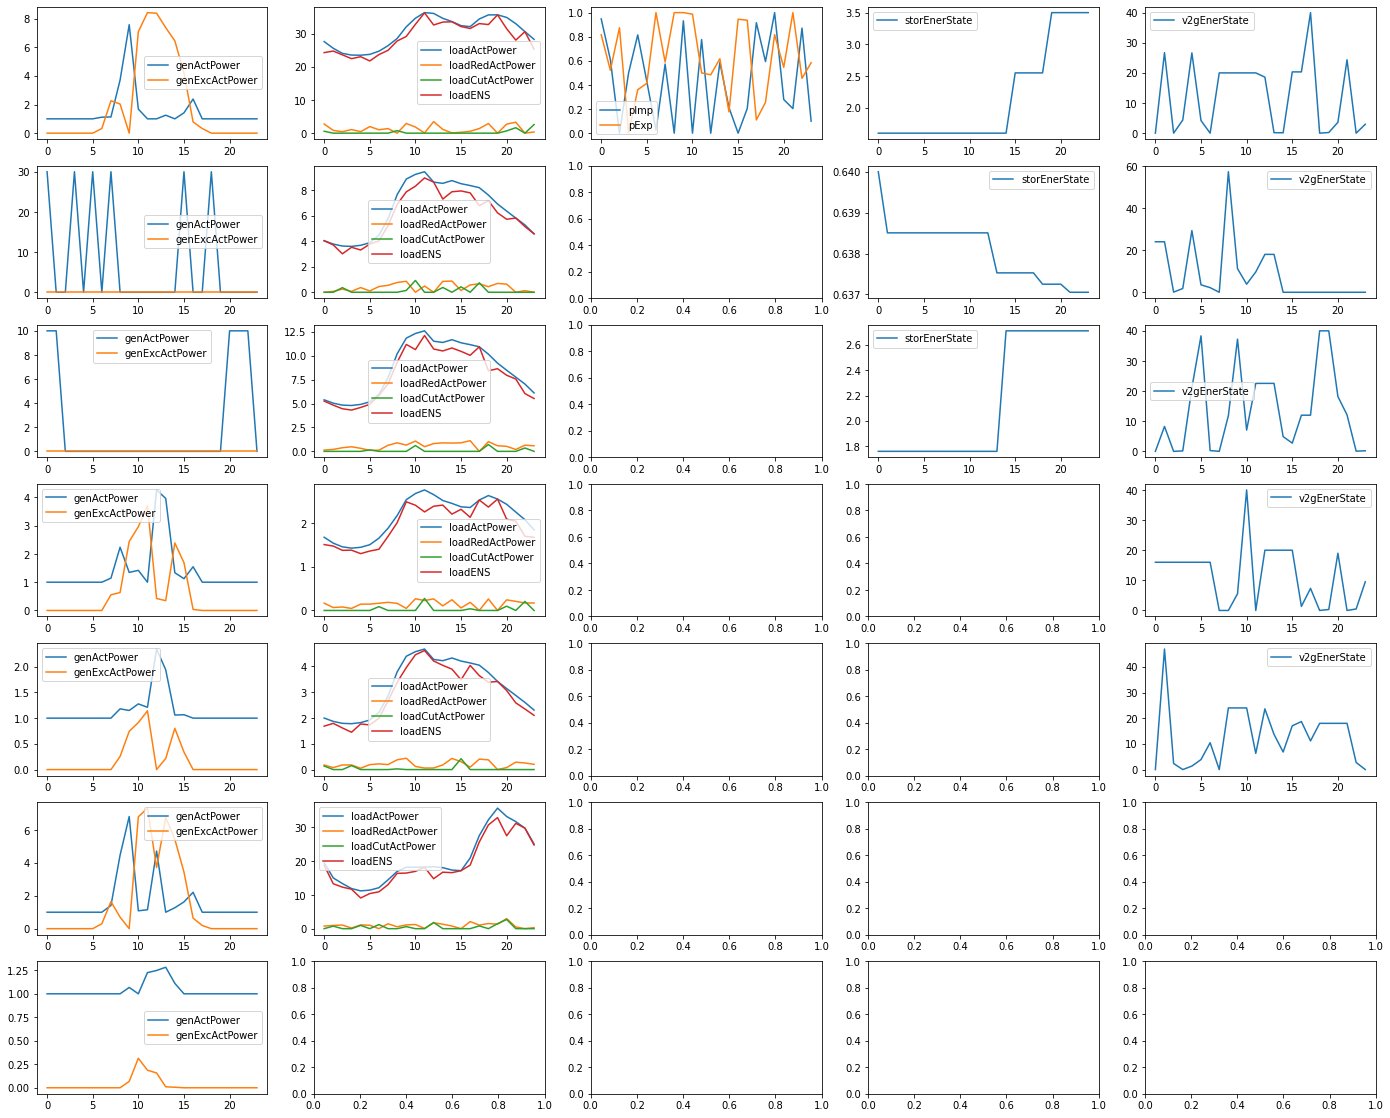

In [223]:
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(24, 20))

PLOT_SOLUTION = 0
temp_decodedsol = decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(temp_decodedsol['genActPower'][i])
    axs[i, 0].plot(temp_decodedsol['genExcActPower'][i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(temp_decodedsol['loadRedActPower'][i])
    axs[i, 1].plot(temp_decodedsol['loadCutActPower'][i])
    axs[i, 1].plot(temp_decodedsol['loadENS'][i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(temp_decodedsol['pImp'])
axs[0, 2].plot(temp_decodedsol['pExp'])
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(temp_decodedsol['storEnerState'][i])
    axs[i, 3].legend(['storEnerState'])

for i in range(5):
    axs[i, 4].plot(temp_decodedsol['v2gEnerState'][i])
    axs[i, 4].legend(['v2gEnerState'])

#plt.plot(np.sum(decode(trial_results['Solution'][0], dict_var)['genActPower'], axis=0))

plt.show()

In [ ]:
# Imports and Exports

plt.plot(decode(trial_results['Solution'][0], dict_var)['pImp'])
plt.plot(decode(trial_results['Solution'][0], dict_var)['pExp'])

plt.legend(['pImp', 'pExp'])

In [12]:
%load_ext cython

In [2]:
%%cython

import cython

import numpy as np
cimport numpy as np

# differential evolution search of the two-dimensional sphere objective function
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
from numpy import argmin
from numpy import min
from numpy import around

import scipy
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.array([1]) #np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(period)
_gen = np.arange(gen)
_Load = np.arange(Load)
_stor = np.arange(stor)
_v2g = np.arange(v2g)
_cs = np.arange(cs)

#positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# # binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))



# Define dictionaries
dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadCutActPower': loadCutActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            'storEnerState': storEnerState,
            'v2gDchActPower': v2gDchActPower,
            'v2gChActPower': v2gChActPower,
            'v2gEnerState': v2gEnerState,
            'EminRelaxEv': v2gEminRelaxEv,
            'csActPower': csActPower,
            'csActPowerNet': csActPowerNet,
            'genXo': genXo,
            'loadXo': loadXo,
            'storChXo': storChXo,
            'storDchXo': storDchXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g}

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadCutActPower': np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': np.array(np.zeros((1, storEnerState.ravel().shape[0]))),
           'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'v2gEnerState': np.array(np.zeros((1, v2gEnerState.ravel().shape[0]))),
           'EminRelaxEv': np.array(np.zeros((1, v2gEminRelaxEv.ravel().shape[0]))),
           'csActPower': (csInfo[:, 5] * -1 * csActPower.transpose()).transpose().ravel(),
           'csActPowerNet': np.array(np.zeros((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}


maxVals = {'genActPower': 200*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 200*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           #'loadRedActPower': 200*np.array(np.ones((1, loadRedActPower.ravel().shape[0]))),
           #par['loadLimit'][l, t, 2]
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           #'loadCutActPower': 200*np.array(np.ones((1, loadCutActPower.ravel().shape[0]))),
           'loadCutActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': 200*np.array(np.ones((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': 200*np.array(np.ones((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': 200*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': np.array(np.ones((1, storEnerState.ravel().shape[0]))),
           'storEnerState': (storInfo[:, 5] * storEminRelaxStor.transpose()).transpose().ravel(),
           'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'v2gEnerState': (v2gInfo[:, 4] * v2gEnerState.transpose()).transpose().ravel(),
           'EminRelaxEv': 200*np.array(np.ones((1, v2gEminRelaxEv.ravel().shape[0]))),
           'csActPower': (csInfo[:, 4] * csActPower.transpose()).transpose().ravel(),
           'csActPowerNet': 200*np.array(np.ones((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}


# Turn and recover vector for encoding
def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat

def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded



# Generation checks
def check_pop_gens(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the boolean variables
    pop['genXo'] = (pop['genXo'] > 0.5).astype(int)
    
    g: cython.int
        
    # Go through generators
    for g in range(pop['genActPower'].shape[0]):
        
        # Check generator type
        if par['genInfo'][g, 4] != 1:
            
            # Maximum generation in generators with normal contract
            pop['genActPower'][g, :][pop['genActPower'][g, :] > par['genLimit'][g, :, 0]] = par['genLimit'][g, :, 0][pop['genActPower'][g, :] > par['genLimit'][g, :, 0]]

            # Minimum generation
            pop['genActPower'][g, :][pop['genActPower'][g, :] < par['genInfo'][g, 6] * pop['genXo'][g, :]] = (par['genInfo'][g, 6] * pop['genXo'][g, :])[pop['genActPower'][g, :] < par['genInfo'][g, 6] * pop['genXo'][g, :]]
                
        elif par['genInfo'][g, 4] != 2:
            # Generate the genExcActPower variable according to the equality equation
            pop['genExcActPower'][g, :] = par['genLimit'][g, :, 0] - pop['genActPower'][g, :]
            
    return encode(pop)

# Check loads
def check_pop_loads(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the boolean variables
    pop['loadXo'] = (pop['loadXo'] > 0.5).astype(int)
    
    l: cython.int
    
    # Go through the loads
    pop['loadCutActPower'][:, :] = par['loadLimit'][:, :, 3] * pop['loadXo'][:, :]
    
    temp_val = par['loadActPower'] - pop['loadRedActPower'] - pop['loadCutActPower']
    pop['loadENS'][pop['loadENS'] > temp_val] = temp_val[pop['loadENS'] > temp_val]
    
    return encode(pop)

# Check storage
def check_pop_stor(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the binary variables
    pop['storChXo'] = (pop['storChXo'] > 0.5).astype(int)
    pop['storDchXo'] = (pop['storDchXo'] > 0.5).astype(int)
    
    s: cython.int
    mask = None
    
    for s in range(pop['storDchActPower'].shape[0]):
        # Timestep
        for t in np.arange(1, pop['storDchActPower'].shape[1]):
            # Storage charge and discharge incompatibility
            if pop['storChXo'][s, t] + pop['storDchXo'][s, t] > 1:
                pop['storChXo'][s, t] = 1
                pop['storDchXo'][s, t] = 0
                
    # Discharge inequality
    mask = pop['storDchActPower'] > par['storLimit'][:, :, 1] * pop['storDchXo']
    pop['storDchActPower'][mask] = (par['storLimit'][:, :, 1] * pop['storDchXo'])[mask]

    # Storage charge check
    mask = pop['storChActPower'] > par['storLimit'][:, :, 0] * pop['storChXo']
    pop['storChActPower'][mask] = (par['storLimit'][:, :, 0] * pop['storChXo'])[mask]
                
    # Storage relax constraint
    temp_val = [par['storInfo'][:, 6] * par['storInfo'][:, 5] - pop['EminRelaxStor'][:, t] for t in range(par['t'].shape[0])]
    temp_val = np.array(temp_val).transpose()
    mask = pop['storEnerState'] < temp_val
    pop['storEnerState'][mask] = temp_val[mask]
                
    # Battery update rules - t=0
    pop['storEnerState'][:, 0] = par['storInfo'][:, 5] * par['storInfo'][:, 9]/100 + pop['storChActPower'][:, 0] * par['storInfo'][:, 7]/100 - pop['storDchActPower'][:, 0]/par['storInfo'][:, 8] / 100
        
    # Battery update rules - t > 0
    temp_val = [pop['storChActPower'][:, t] * par['storInfo'][:, 7]/100 - pop['storDchActPower'][:, t]/par['storInfo'][:, 8]/100 for t in range(1, par['t'].shape[0])]
    temp_val = np.array(temp_val).transpose()
    pop['storEnerState'][:, 1:] = pop['storEnerState'][:, :-1] + temp_val

    return encode(pop)

# Check v2g
def check_pop_v2g(val, par, val_dictionary):
    
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound binary variables
    pop['v2gChXo'] = (pop['v2gChXo'] > 0.5).astype(int)
    pop['v2gDchXo'] = (pop['v2gDchXo'] > 0.5).astype(int)
    
    mask = None
    
    v: cython.int
    
    # V2G constraints
    for v in range(pop['v2gChActPower'].shape[0]):
        
        # Timestep
        for t in np.arange(pop['v2gChActPower'].shape[1]):
            
            # Disable charge and discharge in the same period
            if pop['v2gChXo'][v, t] + pop['v2gDchXo'][v, t] > 1:
                pop['v2gChXo'][v, t] = 1
                pop['v2gDchXo'][v, t] = 0
                
    # Discharge rate
    temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0] * pop['v2gDchXo']
    mask = pop['v2gDchActPower'] > temp_val
    pop['v2gDchActPower'][mask] = temp_val[mask]
    
    
    # Charge rate
    temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0] * pop['v2gChXo']
    mask = pop['v2gChActPower'] > temp_val
    pop['v2gChActPower'][mask] = temp_val[mask]
             
        
    # Energy Limits Eq1
    mask = pop['v2gEnerState'] < par['v2gLimit'][:, :, 2] - pop['EminRelaxEv']
    mask2 = par['v2gLimit'][:, :, 0] == 1
    pop['v2gEnerState'][mask & mask2] = par['v2gLimit'][:, :, 2][mask & mask2] - pop['EminRelaxEv'][mask & mask2]
    

    # Energy Limits Eq2
    mask = [(par['v2gLimit'][:, t, 0] == 0) & (par['v2gLimit'][:, t+1, 0] == 0) & (par['v2gLimit'][:, t, 2] == 0)
            for t in range(par['t'].shape[0] - 2)]
    
    mask2 = [pop['v2gEnerState'][:, t] < par['v2gInfo'][:, 4] - pop['EminRelaxEv'][:, t] 
             for t in range(par['t'].shape[0] - 2)]
    
    mask3 = np.array(mask) & np.array(mask2)
    mask3 = mask3.transpose()
    
    temp_val = [par['v2gInfo'][:, 4] - pop['EminRelaxEv'][:, t] for t in range(par['t'].shape[0])]
    temp_val = np.array(temp_val).transpose()
    
    pop['v2gEnerState'][:, :-2][mask3] = temp_val[:, :-2][mask3]

            
    # Energy Limits Eq3
    mask = par['v2gLimit'][:, -1, 0] == 0
    mask2 = par['v2gLimit'][:,-1, 2] == 0
    
    temp_val = [par['v2gInfo'][:, 4] - pop['EminRelaxEv'][:, t]
                for t in range(par['t'].shape[0])]
    temp_val = np.array(temp_val).transpose()
    
    pop['v2gEnerState'][:, -1][mask & mask2] = temp_val[:, -1][mask & mask2]
    
    
    # Energy Balance Initial Eq
    mask = par['v2gLimit'][:, 0, 0] == 0
    temp_val = par['v2gLimit'][:, 0, 1] + pop['v2gChActPower'][:, 0] * par['v2gInfo'][:, 7] - pop['v2gDchActPower'][:, 0] / par['v2gInfo'][:, 8]
    pop['v2gEnerState'][:, 0][mask] = temp_val[mask]
    

    # Energy Balance 1
    mask = par['v2gLimit'][:, :-1, 0] == 1
    mask2 = par['v2gLimit'][:, 1:, 0] == 1
    
    temp_val = [pop['v2gEnerState'][:, t-1] + par['v2gLimit'][:, t, 1] + pop['v2gChActPower'][:, t] * par['v2gInfo'][:, 7] - pop['v2gDchActPower'][:, t] / par['v2gInfo'][:, 8]
                for t in range(1, par['t'].shape[0])]
    temp_val = np.array(temp_val).transpose()
    pop['v2gEnerState'][:, 1:][mask & mask2] = temp_val[mask & mask2]
    

    # Energy Balance 2
    mask = par['v2gLimit'][:, :-1, 0] == 0
    #mask2 = par['v2gLimit'][:, 1:, 0] == 1 - same as previous mask
    temp_val = [par['v2gLimit'][:, t, 1] + pop['v2gChActPower'][:, t] * par['v2gInfo'][:, 8] + pop['v2gDchActPower'][:, t] / par['v2gInfo'][:, 9]
                for t in range(1, par['t'].shape[0])] 
    temp_val = np.array(temp_val).transpose()
    pop['v2gEnerState'][:, 1:][mask & mask2] = temp_val[mask & mask2]
    
    return encode(pop)

# Check charging stations
def check_pop_cs(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    c: cython.int
    
    # Charging station constraints
    for c in range(pop['csActPower'].shape[0]):
        
        # Timesteps
        for t in range(pop['csActPower'].shape[1]):
            
            temp_val = 0
            temp_val2 = 0
            for v in np.arange(par['v2g'][-1]):
                if par['EV_CS_Info'][v, c, t] > 0:
                    temp_val += (pop['v2gChActPower'][v, t]  - pop['v2gDchActPower'][v, t])
                    temp_val2 += (pop['v2gChActPower'][v, t] / (par['csInfo'][c, 6] / 100) - pop['v2gDchActPower'][v, t] * par['csInfo'][c, 7] / 100) 
                    
            pop['csActPower'][c, t] = temp_val
            pop['csActPowerNet'][c, t] = temp_val2
    
    return encode(pop)

# define mutation operation
def mutation(x, F):
    return x[0] + F * (x[1] - x[2])


# define boundary check operation
def check_bounds(mutated, bounds):
    mutated_bound = [clip(mutated[i], bounds[i, 0], bounds[i, 1]) for i in range(len(bounds))]
    return mutated_bound

def check_pops(mutated):
    mutated = check_pop_gens(mutated, dict_par, dict_var)
    mutated = check_pop_loads(mutated, dict_par, dict_var)
    mutated = check_pop_stor(mutated, dict_par, dict_var)
    mutated = check_pop_v2g(mutated, dict_par, dict_var)
    mutated = check_pop_cs(mutated, dict_par, dict_var)
    
    return mutated

# define crossover operation
def crossover(mutated, target, dims, cr):
    # generate a uniform random value for every dimension
    p = rand(dims)
    # generate trial vector by binomial crossover
    trial = [mutated[i] if p[i] < cr else target[i] for i in range(dims)]
    return trial


def eso_obj(vals):
    par = dict_par

    #obj_value = []
    var = decode(vals, dict_var)
    
    temp_gens: cython.float[7*24] = var['genActPower'] * par['genLimit'][:, :, 2] + var['genExcActPower'] * par['genLimit'][:, :, 4]
    sum_gens: cython.float = sum(sum(temp_gens))
    
    temp_loads: cython.float[6*24] = var['loadRedActPower'] * par['loadLimit'][:, :, 6] + var['loadCutActPower'] * par['loadLimit'][:, :, 7] + var['loadENS'] * par['loadLimit'][:, :, 9]
    sum_loads:cython.float = sum(sum(temp_loads))
    
    temp_stor: cython.float[3*24] = var['storDchActPower'] * par['storLimit'][:, :, 3] - var['storChActPower'] * par['storLimit'][:, :, 2] + var['EminRelaxStor'] * 200 
    sum_stor: cython.float = sum(sum(temp_stor))
    
    temp_v2g: cython.float[5*24] = var['v2gDchActPower'] * par['v2gLimit'][:, :, 6] - var['v2gChActPower'] * par['v2gLimit'][:, :, 5] + var['EminRelaxEv'] * 200
    sum_v2g: cython.float = sum(sum(temp_v2g))
    
    temp_rest: cython.float[24]  = var['pImp'] * par['buyPrice'] - var['pExp'] * par['sellPrice']
    sum_rest: cython.float = sum(sum(temp_rest))


    # Objective function values
    #temp_gens = sum([var['genActPower'][g, t] * par['genLimit'][g, t, 2] + var['genExcActPower'][g, t] * par['genLimit'][g, t, 4]
    #                 for t in np.arange(par['t'][-1]) for g in np.arange(par['gen'][-1])])

    #temp_loads = sum([var['loadRedActPower'][l, t] * par['loadLimit'][l, t, 6] + var['loadCutActPower'][l, t] * par['loadLimit'][l, t, 7] + var['loadENS'][l, t] * par['loadLimit'][l, t, 9] 
    #                  for t in np.arange(par['t'][-1]) for l in np.arange(par['load'][-1])])

    #temp_stor = sum([var['storDchActPower'][s, t] * par['storLimit'][s, t, 3] - var['storChActPower'][s, t] * par['storLimit'][s, t, 2] + var['EminRelaxStor'][s, t] * 200 
    #                 for t in np.arange(par['t'][-1]) for s in np.arange(par['stor'][-1])])

    #temp_v2g = sum([var['v2gDchActPower'][v, t] * par['v2gLimit'][v, t, 6] - var['v2gChActPower'][v, t] * par['v2gLimit'][v, t, 5] + var['EminRelaxEv'][v, t] * 200
    #                for t in np.arange(par['t'][-1]) for v in np.arange(par['v2g'][-1])])

    #temp_rest = sum([var['pImp'][i] * par['buyPrice'][i] - var['pExp'][i] * par['sellPrice'][i] 
    #                 for i in np.arange(par['t'][-1])])

    #obj_value.append(temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)

    #obj_value = np.reshape(obj_value, (vals.shape[0], 1))

    return sum_gens + sum_loads + sum_stor + sum_v2g + sum_rest


# define population size
pop_size = 50
# define lower and upper bounds for every dimension
#bounds = asarray([(-5.0, 5.0), (-5.0, 5.0)])
bounds = asarray(list(zip(encode(minVals), encode(maxVals))))
# define number of iterations
iters = int(1e5)
# define scale factor for mutation
F = 0.5
# define crossover rate for recombination
cr = 0.7

def differential_evolution(pop_size, bounds, iters, F, cr):
    # initialise population of candidate solutions randomly within the specified bounds
    pop: cython.float[10*2424] = bounds[:, 0] + (rand(pop_size, len(bounds)) * (bounds[:, 1] - bounds[:, 0]))
    # evaluate initial population of candidate solutions
    obj_all: cython.float[10] = [eso_obj(pop[ind, :]) for ind in range(pop.shape[0])]
    #obj_all = eso_obj(pop)
    # find the best performing vector of initial population
    best_vector: cython.float = pop[argmin(obj_all)]
    best_obj: cython.float = min(obj_all)
    prev_obj: cython.float = best_obj
    # run iterations of the algorithm

    i: cython.int
    j: cython.int
        
    obj_target: cython.float
    obj_trial: cython.float
        
    mutated: cython.float[10*2424]
    
    for i in range(iters):
        # iterate over all candidate solutions
        for j in range(pop_size):
            # choose three candidates, a, b and c, that are not the current one
            candidates = [candidate for candidate in range(pop_size) if candidate != j]
            a, b, c = pop[choice(candidates, 3, replace=False)]
            # perform mutation
            mutated = mutation([a, b, c], F)
            # check that lower and upper bounds are retained after mutation
            mutated = check_bounds(mutated, bounds)
            # Constraints
            #mutated = check_pop(mutated)
            # perform crossover
            trial = crossover(mutated, pop[j], len(bounds), cr)
            # compute objective function value for target vector
            obj_target = eso_obj(pop[j])
            # compute objective function value for trial vector
            obj_trial = eso_obj(trial)
            # perform selection
            if obj_trial < obj_target:
                # replace the target vector with the trial vector
                pop[j] = check_pops(trial)
                # store the new objective function value
                obj_all[j] = eso_obj(pop[j])#obj_trial
        # find the best performing vector at each iteration
        best_obj = min(obj_all)
        # store the lowest objective function value
        if best_obj < prev_obj:
            best_vector = pop[argmin(obj_all)]
            prev_obj = best_obj
            # report progress at each iteration
            # print('Iteration: %d f([%s]) = %.5f' % (i, around(best_vector, decimals=5), best_obj))
    return [best_vector, best_obj]

# perform differential evolution
solution = differential_evolution(pop_size, bounds, iters, F, cr)
#print('\nSolution: f([%s]) = %.5f' % (around(solution[0], decimals=5), solution[1]))

UsageError: Cell magic `%%cython` not found.


In [ ]:
# Batteries -> direct repair